# Exoplanets HW2
## Miles Currie and 

In [113]:
using Pkg
Pkg.add("PyPlot")
Pkg.add("Statistics")
Pkg.add("Printf")
using DelimitedFiles
using PyPlot;
using Statistics
using Printf

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
  [de0858da] + Printf 
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
function load_data(fl_path)
    data = readdlm(fl_path)
    return data
end;

In [3]:
# load data
data_fl = "./mystery_planet02.txt"
data = load_data(data_fl)

# unpack data
time, flux, flux_err = data[:, 1], data[:, 2], data[:, 3];

# Overlap Area of Two Circles

![Image](./overlap.pdf)

### $ A_{\mathrm{overlap}} = A_{\mathrm{occultor}} + A_{\mathrm{emitter}} - A_{\mathrm{kite}} $

### $ A_{\mathrm{occultor}} = R_{\mathrm{occultor}} \kappa_0 =  R_{\mathrm{occultor}}^2 \arccos{\frac{b^2 + R_{\mathrm{occultor}}^2 - R_{\mathrm{emitter}}^2}{2 b R_{\mathrm{occultor}}}}  $


### $ A_{\mathrm{emitter}} = R_{\mathrm{emitter}} \kappa_1 = R_{\mathrm{emitter}}^2 \arccos{\frac{b^2 + R_{\mathrm{emitter}}^2 - R_{\mathrm{occultor}}^2}{2 b R_{\mathrm{emitter}}}}  $

### $ A_{\mathrm{kite}} = \frac{1}{2} \sqrt{(-b + R_{\mathrm{occultor}} + R_{\mathrm{emitter}}) (b + R_{\mathrm{occultor}} - R_{\mathrm{emitter}}) (b - R_{\mathrm{occultor}} + R_{\mathrm{emitter}}) (b + R_{\mathrm{occultor}} + R_{\mathrm{emitter}}) } $


### $ A_{\mathrm{overlap}} = R_{\mathrm{occultor}}^2 \arccos{\frac{b^2 + R_{\mathrm{occultor}}^2 - R_{\mathrm{emitter}}^2}{2 b R_{\mathrm{occultor}}}} + R_{\mathrm{emitter}}^2 \arccos{\frac{b^2 + R_{\mathrm{emitter}}^2 - R_{\mathrm{occultor}}^2}{2 b R_{\mathrm{emitter}}}} - \frac{1}{2} \sqrt{(-b + R_{\mathrm{occultor}} + R_{\mathrm{emitter}}) (b + R_{\mathrm{occultor}} - R_{\mathrm{emitter}}) (b - R_{\mathrm{occultor}} + R_{\mathrm{emitter}}) (b + R_{\mathrm{occultor}} + R_{\mathrm{emitter}}) } $

In [4]:
function overlap_area_myattempt(separation, r_occultor, r_emitter)
    
    area = (r_occultor^2 * acos((separation^2 + r_occultor^2 - r_emitter^2) / (2*separation*r_occultor))
        + r_emitter^2 * acos((separation^2 + r_emitter^2 - r_occultor^2) / (2*separation*r_emitter))
        - 0.5 * sqrt((-separation + r_occultor + r_emitter) * (separation + r_occultor - r_emitter)
            * (separation - r_occultor + r_emitter) * (separation + r_occultor + r_emitter)))
    return area
end;

In [5]:
function overlap_area(x, r_p, d)
    # using bat-formalism 
    # x = stellar radius
    # r_p = planet radius
    # d = separation of star and planet centers
        
    # We only care about absolute distance between star and planet (sign doesn't matter)
    d = abs(d)
    
    u = (d^2 + x^2 - r_p^2) / (2*d*x)
    v = (d^2 + r_p^2 - x^2) / (2*d*r_p)
    w = (-d + x + r_p) * (d + x - r_p) * (d - x + r_p) * (d + x + r_p)
    
    if d >= r_p + x
        area = 0
    elseif r_p - d < x < r_p + d
        area = x^2*acos(u) + r_p^2*acos(v) - 0.5*sqrt(w)
    elseif x <= r_p - d
        area = pi * x^2
    elseif x >= r_p + d
        area = pi * r_p^2
    
    end
    
    return area
end

overlap_area (generic function with 1 method)

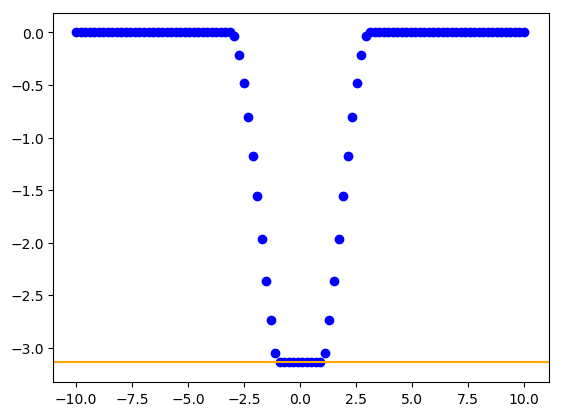

In [6]:
distances = range(-10, stop=10, length=100)
stellar_radius = 2
planet_radius = 1

for (t, d) in enumerate(distances)
    area = overlap_area(stellar_radius, planet_radius, d)
    scatter(d, -area, c=:blue)
end
axhline(-pi, color="orange")
show()

# Layer-Cake a la Batman

$$
\delta(d; r_p) = \sum_{i = 1}^n \Delta \delta_i(d; r_p)
$$
$$
\Delta \delta_i(d; r_p) = I \left( \frac{x_i + x_{i - 1}}{2} \right) \left[A(x_i, r_p, d) - A(x_{i - 1}, r_p, d)  \right]
$$

In [7]:
# Compute the quantity Delta delta
# I is the intensity profile
# A is the area of overlap function
# r_p is the radius of the planet
# d is the distance
function d_delta(i, x, d, r_p, I)
    avg_x = (x[i] + x[i - 1]) / 2
    delta_A = overlap_area(x[i], r_p, d) - overlap_area(x[i - 1], r_p, d)
    return I(avg_x) * delta_A
end

d_delta (generic function with 1 method)

## Intensity profile as a function of normalized stellar radius $x \in [0, 1] $

In [8]:
function I_const(x)
   return  1
end;

In [9]:
function I_linear(x)
    mu = sqrt(1 - x^2)
    I_0 = 1
    c_1 = 1
    return I_0 * (1 - c_1*(1 - mu))
end;

In [10]:
function I_quadratic(x)
    I_0 = 1
    c_1 = 0.5
    c_2 = 0.5
    mu = sqrt(1 - x^2)
    return I_0 * (1 - c_1*(1 - mu) - c_2 * (1 - mu)^2)
end;

## Computation of delta at single d

In [226]:
function compute_delta(d, planet_radius=0.5; I_func=I_const, num_steps=100)
    x = collect(range(0, stop=1, length=num_steps))
    delta = 0
    for i in range(2, stop=num_steps)
        delta += d_delta(i, x, d, planet_radius, I_func)
    end
    return delta
end;

In [227]:
1 - compute_delta(0, 0.5)

0.21460183660255172

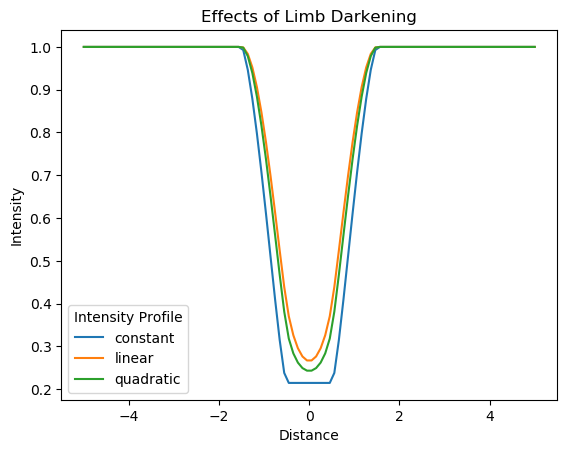

In [12]:
d_grid = collect(range(-5, stop=5, length=100))
deltas_const = []
deltas_linear = []
deltas_quatratic = []

for d in d_grid
    append!(deltas_const, compute_delta(d, I_const))
    append!(deltas_linear, compute_delta(d, I_linear))
    append!(deltas_quatratic, compute_delta(d, I_quadratic)) 
end

figure()
title("Effects of Limb Darkening")
plot(d_grid, 1 .- deltas_const, label="constant")
plot(d_grid, 1 .- deltas_linear, label="linear")
plot(d_grid, 1 .- deltas_quatratic, label="quadratic")
legend(title="Intensity Profile")
xlabel("Distance")
ylabel("Intensity")
show()

# Period finding and transit fitting

Use **model** to fit the data. What is the 
- **Period**: Periodogram (not working)
- **depth**: Fitting transit curve to **folded** data
- **impact parameter**: 
- **duration**

$$ 
T_{I, IV} = \frac{2 \sqrt{(R_{*} + R_P)^2 - (b R_{*})^2}}{v} \approx 2 \sqrt{ 1 - b^2} \frac{R_{*}}{v} ~~(R_P << R_{*})
$$

for $e = 0$

$$
T \approx \frac{\sqrt{1 - b^2} R_{*} P}{\pi a}
$$

$$
T \approx ( \frac{3}{\pi^2} )^{1/3} \sqrt{1 - b^2} P^{1/3} ( G \rho_{*} )^{-1/3}
$$

of the transit. 

What is the **density** of the star.

$$
\rho_{*} = \frac{3}{\pi^2} \frac{P}{G T^3} (1 - b^2)^{3/2}
$$

# Raw Data

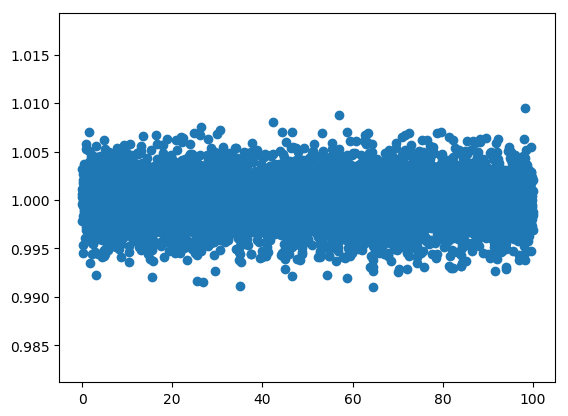

In [13]:
figure()
scatter(time, flux)
show();

In [14]:
function get_phase(time, P)
    phase = (time ./ P) .% 1
    return phase
end;

In [15]:
function compute_scatter(y)
    N = size(y)[1]
    scatter = 0
    for i in range(1, stop=N - 1)
        scatter = scatter + (y[i] - y[i + 1])^2
    end
    return scatter
end;

In [16]:
function periodogram(y, t, P_vals)
    scatters_list = []
    for period in P_vals
        phase = get_phase(t, period)
        phase_sorted_inds = sortperm(phase)
        y_phase_sorted = y[phase_sorted_inds]
        scatter = compute_scatter(y_phase_sorted)
        append!(scatters_list, scatter)
    end
    return scatters_list
end;

In [17]:
function plot_folded_data(time, y, period)
    figure();
    phase = get_phase(time, period)
    scatter(phase, y)
#     errorbar(phase, rv_data, yerr=rv_err, fmt="o", markersize=1, ecolor="k", elinewidth=1, capsize=2, barsabove=true)#, markersize=0, ecolor="k")
    xlabel("Phase")
end;

### Smoothing function that averages over nearest neighbors (running average)

In [28]:
function smooth(y; num_neighbors=2)
    # Make an array to store the smoothed values
    smoothed_ys = []
    for (i, y_i) in enumerate(y)
        # Perform bounds checking to make sure we don't go beyond the edges of the array
        left = convert(Int64, maximum([1, floor(i - num_neighbors / 2)]))
        right = convert(Int64, minimum([size(y)[1], floor(i + num_neighbors / 2)]))
        num = 0
        total = 0
        # Loop over data and accumulate values
        for j in range(left, stop=right)
            num += 1
            total += y[j]
        end
        # Append average to smoothed values array
        append!(smoothed_ys, total / num)
    end
    return smoothed_ys
end;

# Light Curve with various levels of smoothing

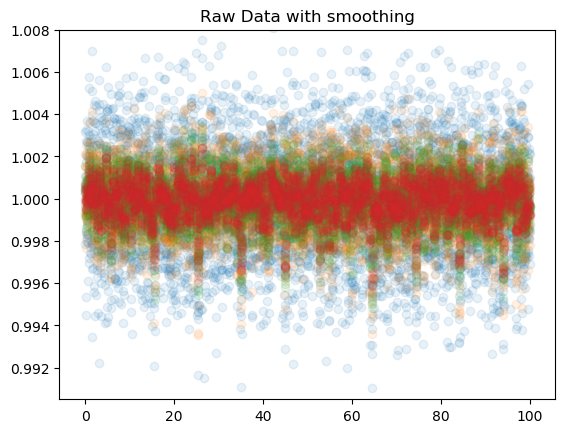

In [30]:
scatter(time, flux, alpha=0.1)
scatter(time, smooth(flux, num_neighbors=2), alpha=0.1)
scatter(time, smooth(flux, num_neighbors=5), alpha=0.1)
scatter(time, smooth(flux, num_neighbors=10), alpha=0.1)
ylim([0.9905, 1.008])
title("Raw Data with smoothing")
show()

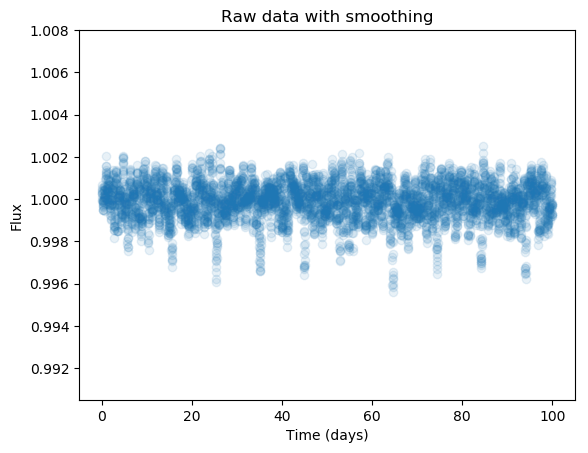

In [31]:
scatter(time, smooth(flux, num_neighbors=10), alpha=0.1)
ylim([0.9905, 1.008])
title("Raw data with smoothing")
xlabel("Time (days)")
ylabel("Flux")
show()

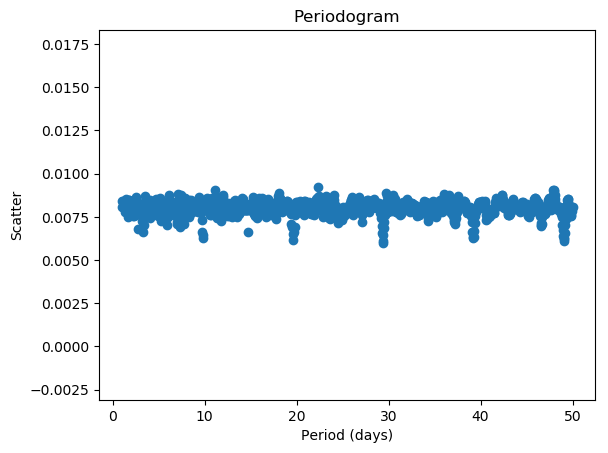

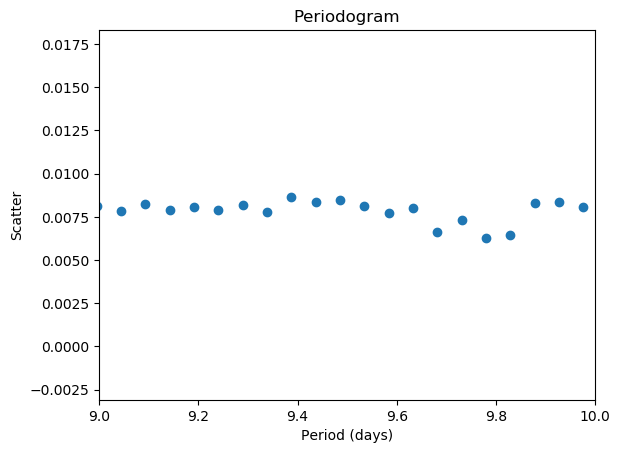

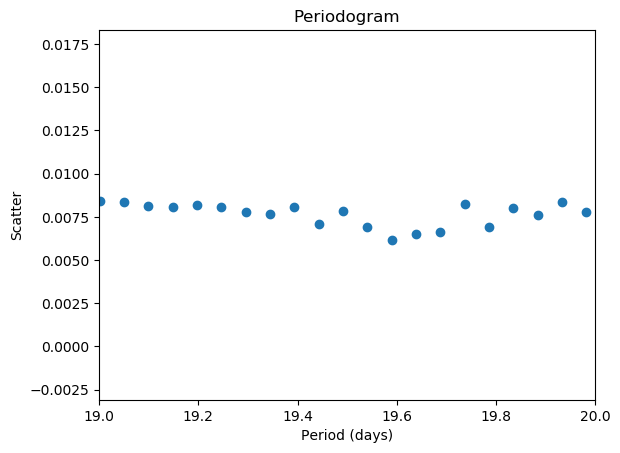

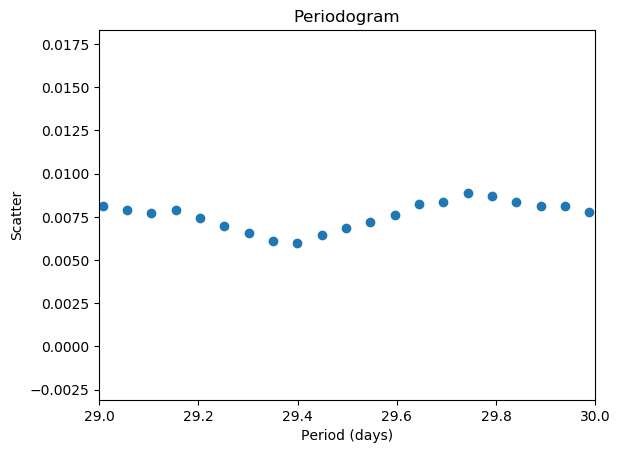

In [32]:
Ps = collect(range(1, stop=50, length=1000))
scatters = periodogram(smooth(flux, num_neighbors=10), time, Ps)
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
show()
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
xlim([9, 10])
show()
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
xlim([19, 20])
show()
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
xlim([29, 30])
show()

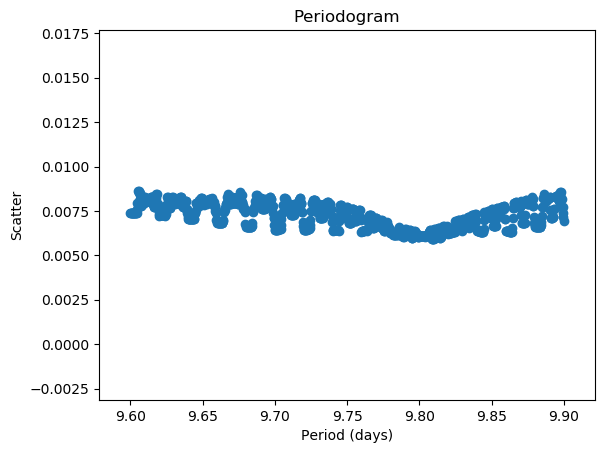

9.809609609609609

In [33]:
Ps = collect(range(9.6, stop=9.9, length=1000))
scatters = periodogram(smooth(flux, num_neighbors=10), time, Ps)
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
show()
P_1 = Ps[argmin(scatters)]

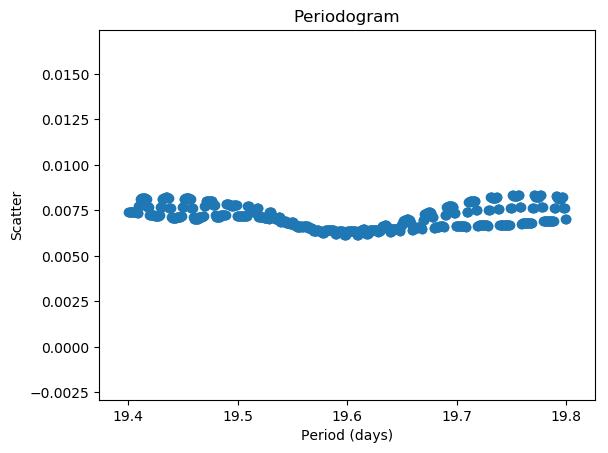

19.597397397397398

In [23]:
Ps = collect(range(19.4, stop=19.8, length=1000))
scatters = periodogram(smooth(flux, k=10), time, Ps)
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
show()
P_2 = Ps[argmin(scatters)]

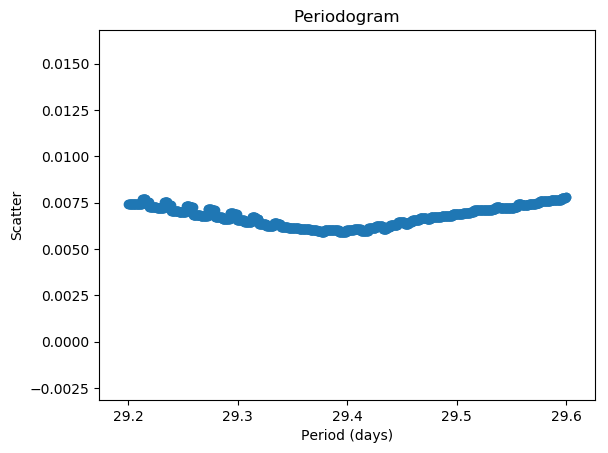

29.392592592592592

In [34]:
Ps = collect(range(29.2, stop=29.6, length=1000))
scatters = periodogram(smooth(flux, num_neighbors=10), time, Ps)
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
show()
P_3 = Ps[argmin(scatters)]

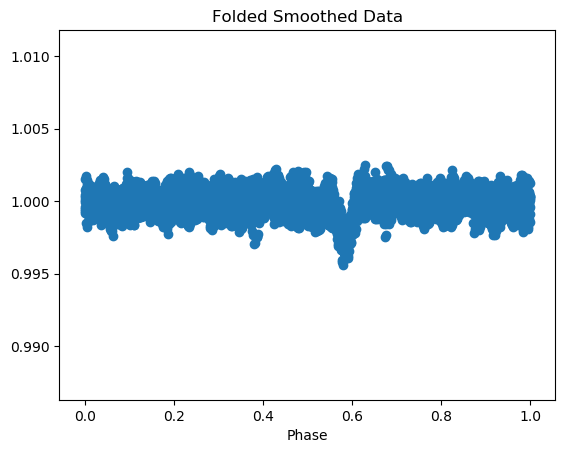

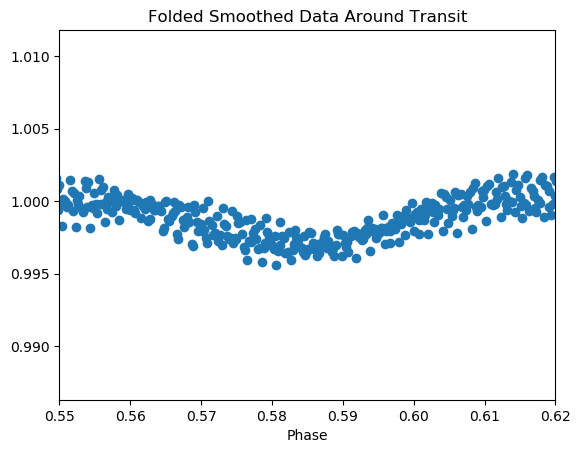

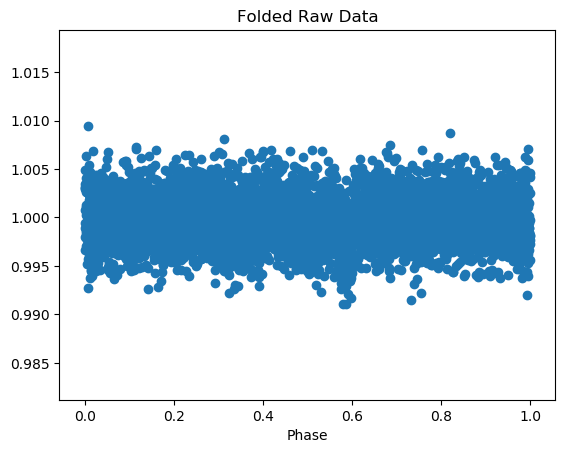

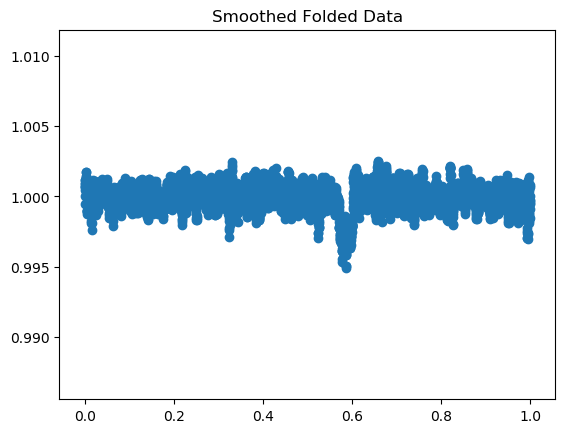

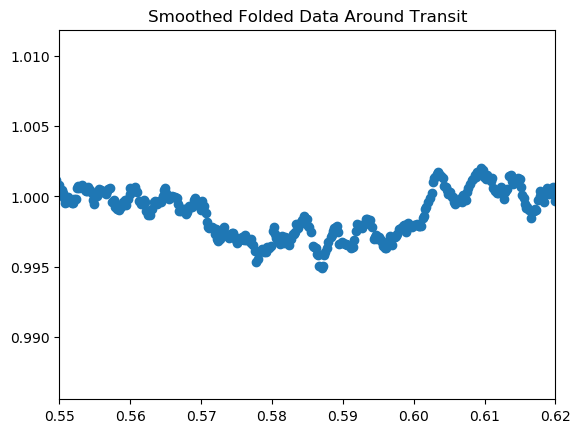

In [35]:
plot_folded_data(time, smooth(flux, num_neighbors=10), P_1)
title("Folded Smoothed Data")
show()

plot_folded_data(time, smooth(flux, num_neighbors=10), P_1)
title("Folded Smoothed Data Around Transit")
xlim([0.55, 0.62])
show()

plot_folded_data(time, flux, P_1)
title("Folded Raw Data")
show()
phase = get_phase(time, P_1)
sorted_phase_idx = sortperm(phase)
flux_by_phase = flux[sorted_phase_idx]

figure()
title("Smoothed Folded Data")
scatter(phase[sorted_phase_idx], smooth(flux_by_phase, num_neighbors=10))
show()
figure()
title("Smoothed Folded Data Around Transit")
scatter(phase[sorted_phase_idx], smooth(flux_by_phase, num_neighbors=10))
xlim([0.55, 0.62])
show()

### Try a periodogram around the correct range for unsmoothed data

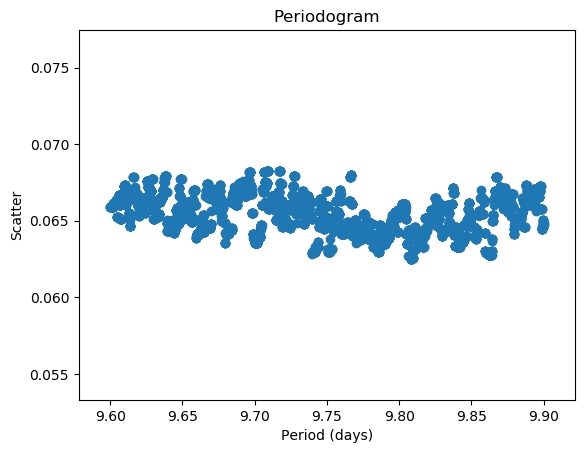

9.808001600320065

In [36]:
Ps = collect(range(9.6, stop=9.9, length=5000))
scatters = periodogram(flux, time, Ps)
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
show()
P_no_smooth = Ps[argmin(scatters)]

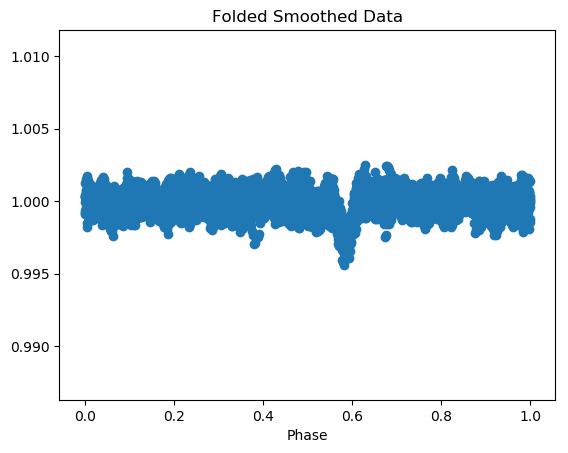

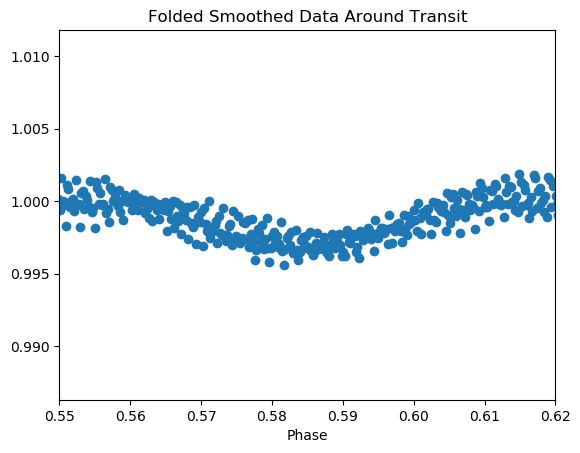

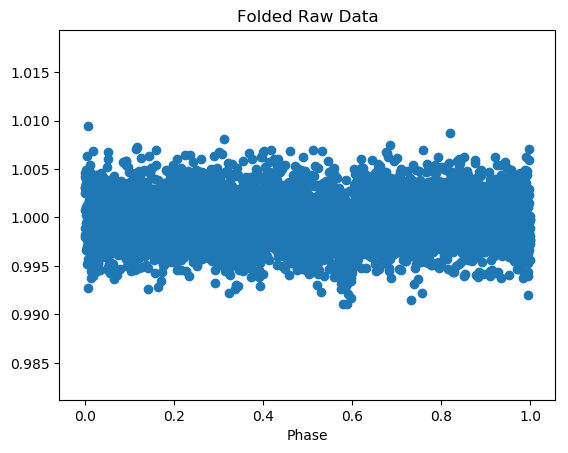

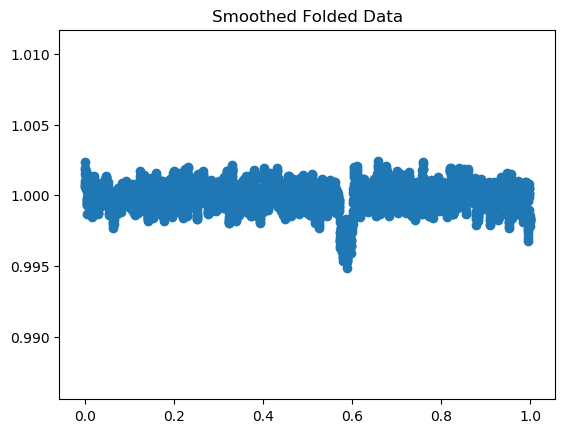

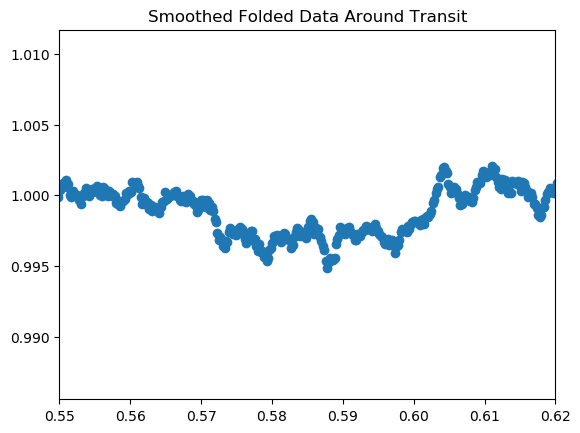

In [37]:
plot_folded_data(time, smooth(flux, num_neighbors=10), P_no_smooth)
title("Folded Smoothed Data")
show()

plot_folded_data(time, smooth(flux, num_neighbors=10), P_no_smooth)
title("Folded Smoothed Data Around Transit")
xlim([0.55, 0.62])
show()

plot_folded_data(time, flux, P_no_smooth)
title("Folded Raw Data")
show()
phase = get_phase(time, P_no_smooth)
sorted_phase_idx = sortperm(phase)
flux_by_phase = flux[sorted_phase_idx]

figure()
title("Smoothed Folded Data")
scatter(phase[sorted_phase_idx], smooth(flux_by_phase, num_neighbors=10))
show()
figure()
title("Smoothed Folded Data Around Transit")
scatter(phase[sorted_phase_idx], smooth(flux_by_phase, num_neighbors=10))
xlim([0.55, 0.62])
show()

# Model the light curve

The separation between the centers of the planet and the star projected along the stellar equator assuming a circular (e = 0) orbit is:

$$
d_{proj}(t; P, t_p, a) = a \cos\left( M(t; P, t_p) \right)
$$

where the mean anomoly is

$$
M(t; P, t_p) = \frac{2\pi}{P} \left( t - t_p \right)
$$

so

$$
d_{proj}(t; P, t_p, a) = a \cos\left( \frac{2\pi}{P} \left( t - t_p \right) \right)
$$

Given an impact parameter $b$ of the orbit, the true distance between the centers of the planet and the star is:

$$
d(t; P, t_p, a, b) = \sqrt{d_{proj}(t; P, t_p, a)^2 + b^2}
$$

Given $d$ and the ratio of the planet and star radii $R_p /R_{*}$, we can compute the fraction of stellar flux of $\delta$ blocked by the transiting planet using the `compute_delta(d, r_p)` function. The flux we see is then $I = I_0*(1 - \delta)$:

$$
I_{model}(t; P, t_p, a, b, R_p / R_{*}) = I_0 \left( 1 - \texttt{compute_delta}\left(d(t; P, t_p, a, b), R_p / R_{*} \right) \right)
$$

Where $I_0$ is the amount of flux received from the unblocked star. $I_{model}(t; P, t_p, a, b, R_p / R_{*})$ is our model light curve. We can optimize over the unknowns $P, t_p, a, b, R_p / R_{*}$ and find that orbital parameters that minimize the chi-squared between the model light curve and the data.

In [45]:
I_0 = median(flux)

0.9998877543977991

In [219]:
function chi_sq(data, data_err, model)
    return sum((data .- model).^2 ./ data_err.^2)
end;

In [228]:
function model_lightcurve(times, P, t_p, a, b, radius_ratio, I_func=I_const, num_steps=100)
    if a - r_p < 1
        print("Warning! Planet interstects star: difference between semi-major axis a and planet radius r_p less than one\n") 
        return nothing
    end
    flush(stdout)

    M = 2 * pi / P * (times .- t_p)
    M_mod = (2 * pi / P * (times .- t_p)) .% (2 * pi)
    behind_star = 0 .< M_mod .< pi

    d_proj = a * cos.(M)
    d = sign.(d_proj) .* sqrt.(d_proj.^2 .+ b^2)
    flux_model = I_0 .* ( 1 .- compute_delta.(d, radius_ratio, I_func=I_func, num_steps=num_steps) )

    flux_model[behind_star] .= 1
    
    return flux_model
end;

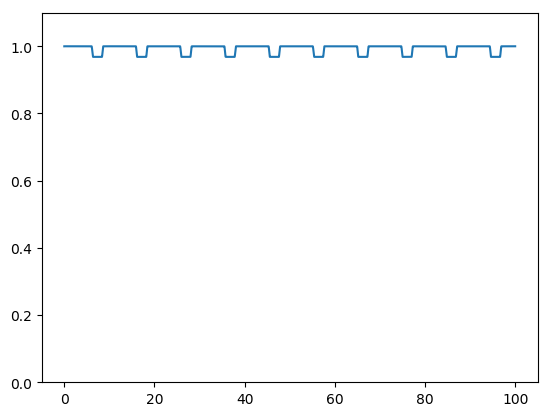

In [235]:
plot(time, model_lightcurve(time, P_1, 0, 1.5, 0, 0.1))
ylim(0, 1.1)
show()

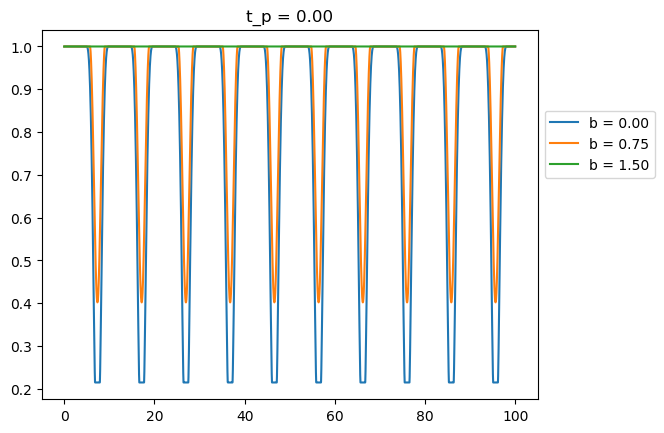

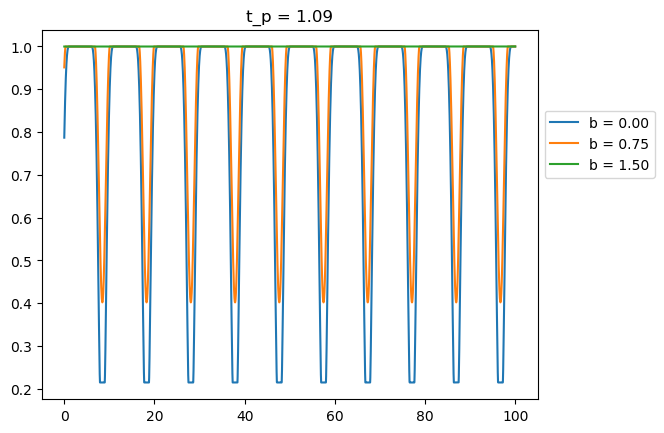

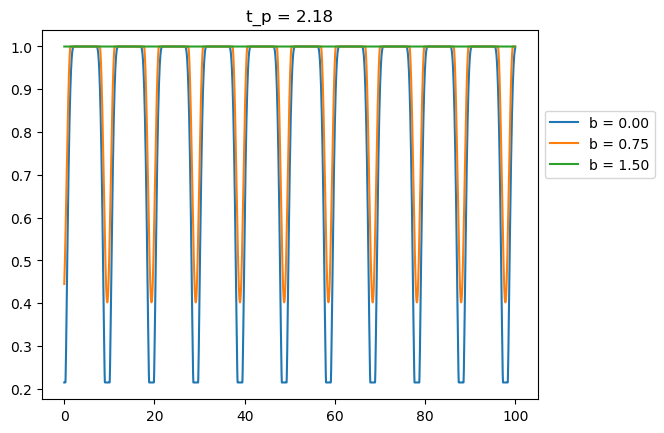

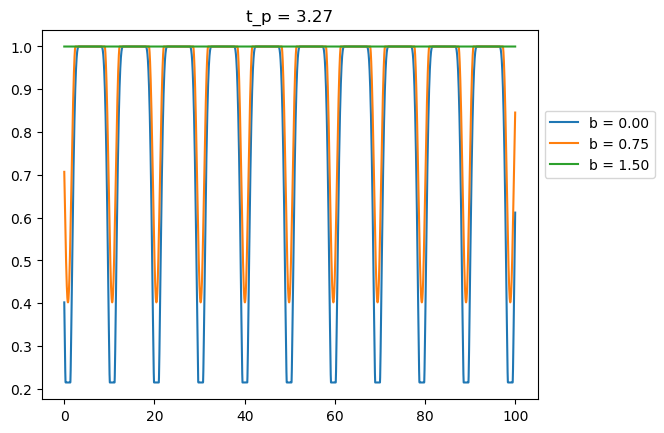

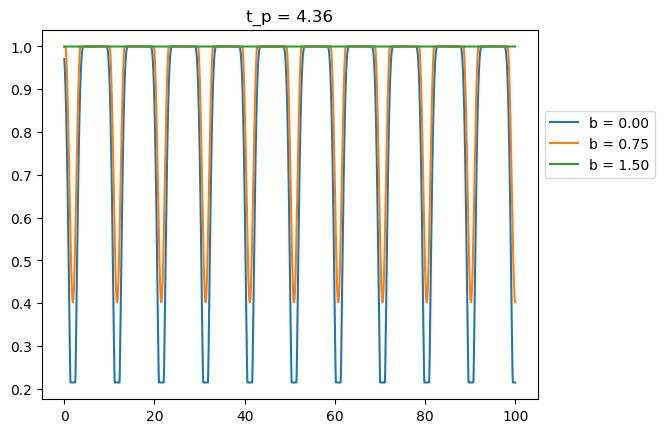

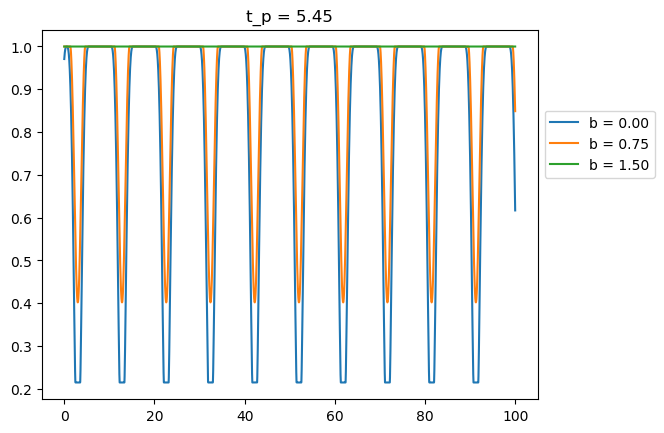

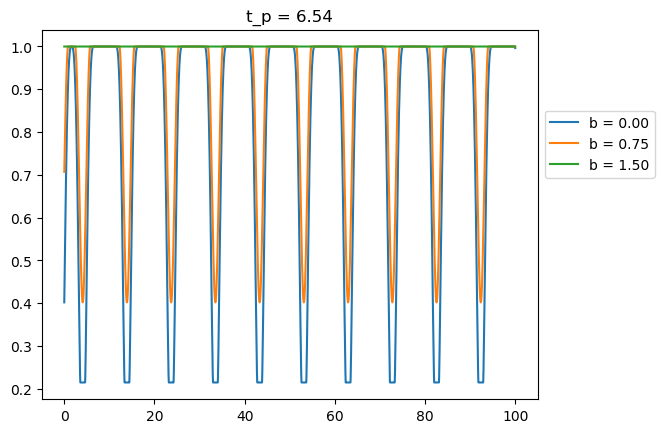

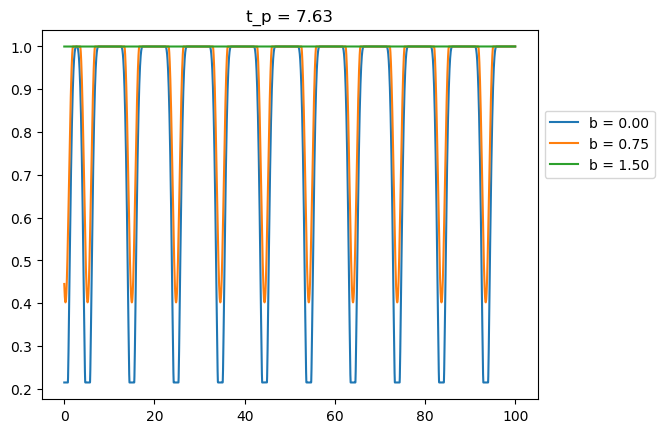

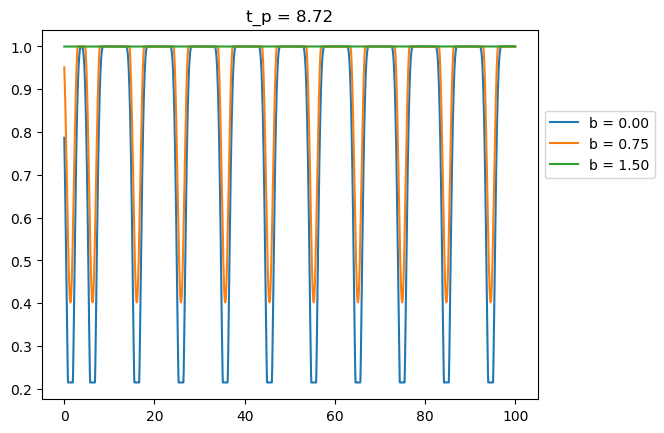

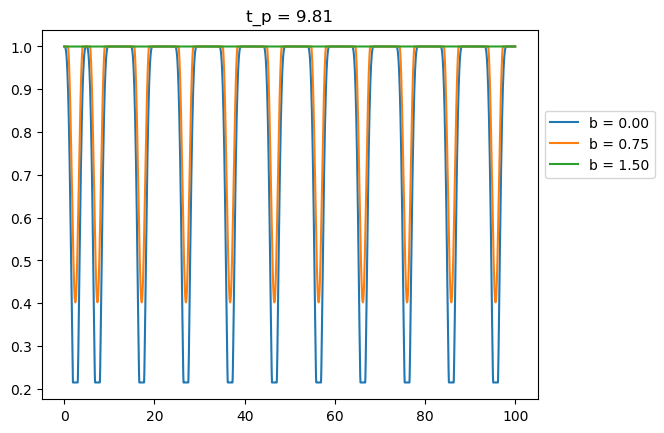

In [217]:
r_p = 0.5
P = P_1
# Units of stellar radii
a = 1.5
t_p = 0.1
# b = 0.5
if a - r_p < 1
   print("Warning! Planet interstects star: difference between semi-major axis a and planet radius r_p less than one\n") 
end
flush(stdout)

for t_p in range(0, stop=P_1, length=10)
    figure()
    # t = collect(range(2.3, stop=2.6, length=100))
    for b in range(0, stop=1 + r_p, length=3)
        M = 2 * pi / P * (time .- t_p)
        M_mod = (2 * pi / P * (time .- t_p)) .% (2 * pi)
        behind_star = 0 .< M_mod .< pi

        d_proj = a * cos.(M)
        d = sign.(d_proj) .* sqrt.(d_proj.^2 .+ b^2)
        flux_model = I_0 *( 1 .- compute_delta.(d, planet_radius=r_p, I_func=I_const, num_steps=100) )
        
        flux_model[behind_star] .= 1
        
        plot(time, flux_model, label=@sprintf("b = %.2f", b))
    end
#     xlim(0, 5)
    legend(bbox_to_anchor=(1.25, 0.8))
    title(@sprintf("t_p = %.2f", t_p))
    show()
end

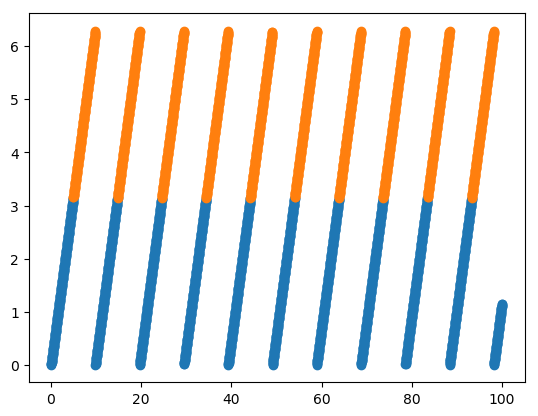

In [212]:
M_mod = (2 * pi / P * (time .- t_p)) .% (2 * pi)
time_behind = time[0 .< M_mod .< pi]
time_front = time[pi .< M_mod .< 2 * pi]
M_behind = M_mod[0 .< M_mod .< pi]
M_front = M_mod[pi .< M_mod .< 2 * pi]
scatter(time_behind, M_behind, label="Behind")
scatter(time_front, M_front, label="Front")
show()

In [205]:
# xlim(2, 3)